In [331]:
import numpy as np
import pandas as pd
import ta
import scipy.stats
from datetime import datetime
import math
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [303]:
df = pd.read_csv("./data/SNP.csv")
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4888,2020-03-26,47.090000,47.799999,46.750000,47.400002,47.400002,281800
4889,2020-03-27,45.889999,46.689999,45.450001,45.509998,45.509998,406600
4890,2020-03-30,46.389999,48.020000,46.389999,47.660000,47.660000,390100
4891,2020-03-31,48.500000,49.320000,48.200001,48.700001,48.700001,223500
4892,2020-04-01,46.020000,48.570000,45.849998,47.529999,47.529999,316500


In [304]:
df = ta.add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Slow : 60+
# Fast : 15
df['date'] = df['Date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d"))
df['dateInt'] = df['date'].apply(lambda x: (x - datetime(1970,1,1)).days)

df.columns[25:]

Index(['volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_r

In [327]:
# Feature Vector Calculations.

df['priceChange'] = df['Close']-df['Open']
df['classPriceChange'] = df['priceChange']>0

# Fast SMA is 12 days
# Slow EMA is 26 days

df['medPrice'] = ((df['High']+df['Low'])/2)
df['typPrice'] = ((df['High']+df['Low']+df['Close'])/3)
df['wtyPrice'] = ((df['High']+df['Low']+2*df['Close'])/3)

In [329]:
df2 = pd.concat(
    [
        df[['classPriceChange','priceChange','date','dateInt']],
        df[list(df.columns[7:93])].shift(1),
        df[list(df.columns[97:])].shift(1)
    ],
    axis=1)
df2 = df2[1:].reset_index(drop=True)
df2.head()

,classPriceChange,priceChange,date,dateInt,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,...,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,medPrice,typPrice,wtyPrice
0,True,0.144231,2000-10-19,11249,0.000000e+00,15145200.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.961538,0.000000,0.000000,0.000000,15.961538,15.961538,21.282051
1,False,-0.096154,2000-10-20,11250,1.255273e+06,13710600.0,0.075711,-620740.700340,-41.246042,-41.246042,...,-7.740651,-1.548130,-6.192521,15.813173,-2.710845,-2.748266,-2.710845,15.192308,15.304487,20.480769
2,False,-0.192308,2000-10-23,11253,9.921726e+05,13447500.0,0.058907,-537484.476675,36.897861,-2.174091,...,-15.505629,-4.339630,-11.165999,15.659287,-0.928793,-0.933133,-3.614460,15.528846,15.480769,20.608974
3,False,-0.192308,2000-10-24,11254,1.318236e+06,12831600.0,0.075506,-503001.797729,-111.647833,-38.665338,...,-22.296319,-7.930968,-14.365351,15.367363,-3.125000,-3.174869,-6.626507,14.687500,14.759615,19.727564
4,False,-0.192308,2000-10-25,11255,9.436240e+05,12157300.0,0.052039,-477456.204173,-9.255149,-31.312791,...,-28.387982,-12.022371,-16.365611,14.956563,-3.225806,-3.278982,-9.638555,14.543269,14.503205,19.310897


In [324]:
all_x = df2[df2.columns[3:]].values
all_y = df2['classPriceChange'].values
#df_input.head()

# Train on the range (01/01/2002) - (12/31/2018), keep (2000-2001) and (2019-2020)
train_test_mask = (df2['date'] <= datetime(2019,1,1))&(df2['date'] >= datetime(2001,1,1))

train_x = all_x[train_test_mask]
train_y = all_y[train_test_mask]

test_x = all_x[~train_test_mask]
test_y = all_y[~train_test_mask]

In [361]:
myPipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',PCA()),
    ('gnb', GaussianNB())])

parameter_grid = {
    'pca__n_components':[10,20,40,80],
    'gnb__var_smoothing':np.logspace(-8,2,11)
}

clf = GridSearchCV(myPipeline,
                   parameter_grid,
                   cv=5,
                   return_train_score=True)
clf.fit(all_x,all_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('gnb', GaussianNB())]),
             param_grid={'gnb__var_smoothing': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02]),
                         'pca__n_components': [10, 20, 40, 80]},
             return_train_score=True)

Best Parameter Selected:	: {'gnb__var_smoothing': 0.1, 'pca__n_components': 20}
Holdout Confusion Matrix
[[190  12]
 [153  10]]
Holdout Model Accuracy:	 0.547945205479452


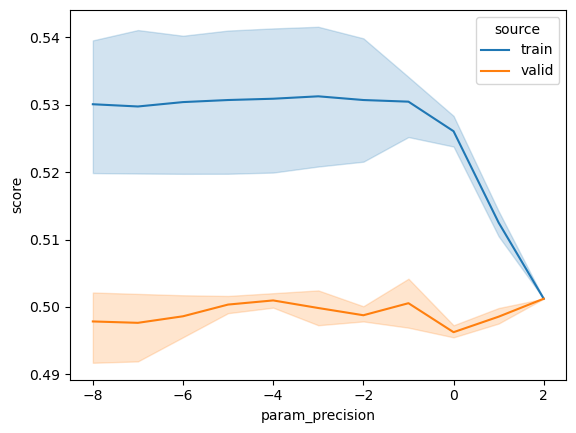

In [362]:
param_precision = [np.log10(x) for x in clf.cv_results_['param_gnb__var_smoothing'].data]

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="param_precision",y='score',hue="source")

test_yhat = clf.best_estimator_.predict(test_x)

print("Best Parameter Selected:\t:",clf.best_params_)
print("Holdout Confusion Matrix")
print(confusion_matrix(test_y,test_yhat))

print("Holdout Model Accuracy:\t",accuracy_score(test_y,test_yhat))

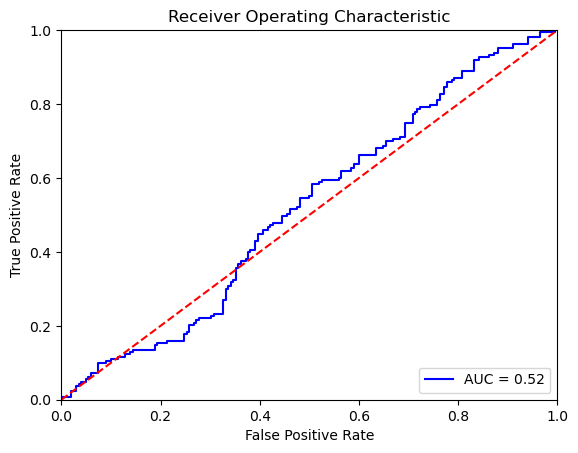

In [357]:
from sklearn import metrics


probs = clf.predict_proba(test_x)
prob_prd = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(test_y, prob_prd)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [363]:
all_x.shape

(4892, 90)

In [364]:
from sklearn.preprocessing import PolynomialFeatures

In [365]:
X = np.arange(6).reshape(3, 2)